# Image Classifier (Deep Learning)

AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


In [1]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## Load the data


In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define your transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
                                      
validation_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.RandomResizedCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
                                      
testing_transforms = transforms.Compose([transforms.Resize(255),
                                         transforms.RandomResizedCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
                                     
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=testing_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
                           


### Label mapping

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
# Confirming number of flower categoies
import pandas as pd
df = pd.DataFrame({'flower_type': cat_to_name})
df.shape[0]

102

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.


* Load a pre-trained network (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [6]:
# Building a network which returns model, optimizer ,criterion
def nn_network(hidden_layer1,hidden_layer2,learning_rate,dropout):
    '''This function is used to build the network.
    Input - Number of hidden layers, learning rate and drop out value
    Output - Returns model, optimizer ,criterion
    '''
    
    # Build and train your network
    model = models.vgg16(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

        classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, hidden_layer1)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=dropout)),
                          ('fc2', nn.Linear(hidden_layer1, hidden_layer2)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(p=dropout)),
                          ('fc3', nn.Linear(hidden_layer2, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    model.classifier = classifier
    
    # Create the network, define the criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    return model, optimizer ,criterion


In [7]:
model, optimizer, criterion = nn_network(4096,512,.001,.2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 93583817.21it/s] 


In [8]:
model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2)
  (fc3): Linear(in_features=512, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [9]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [10]:
criterion

NLLLoss()

In [11]:
# The parameters of the feedforward classifier are appropriately getting trained
model.to ('cuda')
epochs = 4
steps = 0
print_every = 50

for e in range(epochs):
    # Make sure training is back on
    model.train()
    
    for input_label in iter(trainloader):
        running_loss = 0
        inputs, labels = input_label
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        steps += 1
        
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

        if steps % print_every == 0:
            # For Dropout to be turned off
            model.eval () 
            accuracy = 0
            
            for input_label2 in iter(validationloader):
                inputs2, labels2 = input_label2
                inputs2, labels2 = inputs2.to('cuda'), labels2.to('cuda')

                optimizer.zero_grad()
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():    
                    output2 = model.forward(inputs2)
                    loss2 = criterion(output2,labels2)
                
                
                    # Calculate accuracy
                    ps = torch.exp(output2)
                    equality = (labels2.data == ps.max(dim=1)[1])
                    accuracy += equality.type(torch.FloatTensor).mean()
                    
                    #Printing losses and accuracy
                    print(f"Epoch {e+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Validation loss: {loss2/len(validationloader):.3f}.. "
                      f"Validation accuracy: {accuracy/len(validationloader):.3f}")

            



Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.207.. Validation accuracy: 0.025
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.185.. Validation accuracy: 0.066
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.190.. Validation accuracy: 0.101
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.197.. Validation accuracy: 0.139
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.145.. Validation accuracy: 0.188
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.185.. Validation accuracy: 0.221
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.207.. Validation accuracy: 0.249
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.169.. Validation accuracy: 0.291
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.161.. Validation accuracy: 0.332
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.207.. Validation accuracy: 0.358
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.206.. Validation accuracy: 0.383
Epoch 1/4.. Train loss: 0.053.. Validation loss: 0.201.. Validation accuracy

## Testing your network

In [12]:
# Do validation on the test set
correct_all = 0
total_all = 0
i = 1
#Similar to the validation set
with torch.no_grad ():
    for input_label_test in testloader:
        inputs_test, labels_test = input_label_test
        inputs_test, labels_test = inputs_test.to('cuda'), labels_test.to('cuda')
        output_test = model (inputs_test)
        _, predicted = torch.max (output_test.data,1)
        # Calculating the accuracy of test, and finally average of all tests.
        total = labels_test.size (0)
        correct = (predicted == labels_test).sum().item()
        print('Test image accuracy %d: %d %%' % (i, 100 * correct / total))  
        i = i+1
        total_all += labels_test.size (0)
        correct_all += (predicted == labels_test).sum().item()
        

print('Average Accuracy on test images: %d %%' % (100 * correct_all / total_all))

Test image accuracy 1: 73 %
Test image accuracy 2: 67 %
Test image accuracy 3: 75 %
Test image accuracy 4: 65 %
Test image accuracy 5: 79 %
Test image accuracy 6: 73 %
Test image accuracy 7: 67 %
Test image accuracy 8: 75 %
Test image accuracy 9: 73 %
Test image accuracy 10: 70 %
Test image accuracy 11: 71 %
Test image accuracy 12: 78 %
Test image accuracy 13: 76 %
Average Accuracy on test images: 72 %


## Save the checkpoint

In [13]:
model.to ('cpu') 

model.class_to_idx = train_data.class_to_idx

# Save the checkpoint 
checkpoint = {'classifier': model.classifier,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict(),
              'class_to_idx' : model.class_to_idx,
              'epochs': epochs
              
}
torch.save(checkpoint, 'checkpoint.pth')



## Loading the checkpoint

In [14]:
model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2)
  (fc3): Linear(in_features=512, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [15]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['class_to_idx']
    return model

In [16]:
model = load_checkpoint('checkpoint.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
        
    '''
    # Process a PIL image for use in a PyTorch model
    # Will use a similar technique as above using transform.Compose for resizing, cropping and normalizing.
    pil_image = Image.open(image)
   
    transformation_pil_image = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = transformation_pil_image(pil_image)
    
    return img
    
    

img = (data_dir + '/test' + '/1/' + 'image_06764.jpg')
img = process_image(img)
print(img.shape)
    

torch.Size([3, 224, 224])


The function below converts a PyTorch tensor and displays it in the notebook. 

In [18]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

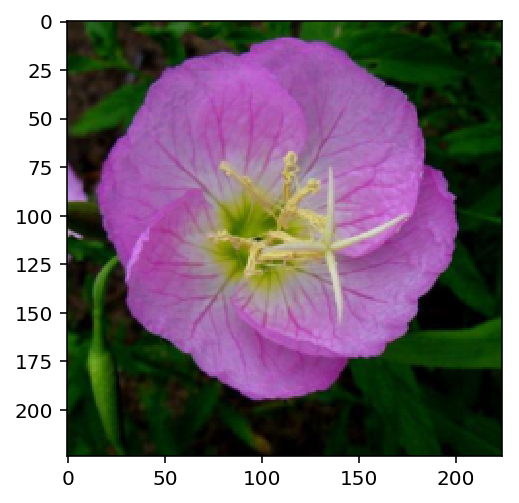

In [19]:
# Testing the process_image functionality using the an image in test folder
image_path = 'flowers/test/1/image_06764.jpg'
img = process_image(image_path)

imshow(img)

## Class Prediction

In [20]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to('cuda')
    image_data = process_image(image_path)
    image_data = image_data.unsqueeze_(0)
    image_data = image_data.to('cuda')
    
    model.eval()
    with torch.no_grad ():
        output = model.forward (image_data)
    predictions = torch.exp (output)
    
    # Identify top predictions and top labels
    probs, classes = predictions.topk(5)
    return probs, classes

In [21]:
# Implement the code to predict the class from an image file
image_path = (data_dir + '/test' + '/1/' + 'image_06764.jpg')
probs, classes = predict(image_path, model)

print(probs)
print(classes)

tensor([[ 0.6096,  0.3362,  0.0360,  0.0089,  0.0019]], device='cuda:0')
tensor([[   0,   99,   98,   53,  100]], device='cuda:0')


In [22]:
#converting into numpy arrays
probs = probs.to('cpu')
classes = classes.to('cpu')
probs_array = np.array(probs.detach().numpy().tolist())
classes_array = np.array(classes.detach().numpy().tolist())
probs_array = probs_array.reshape(5)
classes_array = classes_array.reshape(5)


In [23]:
#creating a DF with flower and preditions 
class_index = pd.Series(model.class_to_idx)
class_flower = pd.Series(cat_to_name)
df = pd.DataFrame({'classes': class_index,'flower':class_flower})
df = df.set_index('classes')
df = df.iloc[classes_array]
df['predictions'] = probs_array
df
    

,flower,predictions
classes,,
0,pink primrose,0.609593
99,mallow,0.336186
98,camellia,0.036018
53,pelargonium,0.008881
100,mexican petunia,0.001895


## Sanity Checking

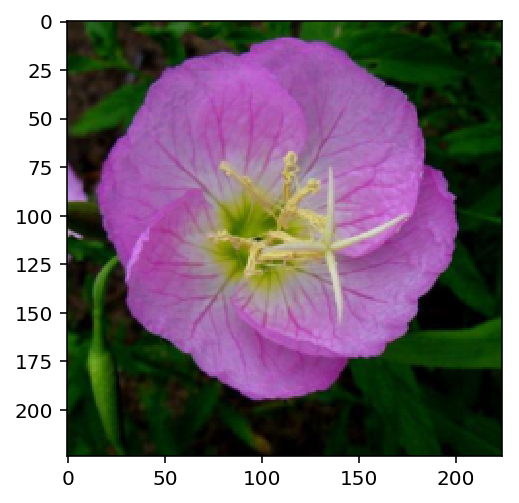

In [24]:
# Display an image along with the top 5 classes
# check_sanity1 to display image, check_sanity2 for calculating highest predictions
def check_sanity1():
    image_path = 'flowers/test/1/image_06764.jpg'
    img = process_image(image_path)

    imshow(img)

def check_sanity2(df):
    plt.figsize=(9, 3)
    plt.barh('flower', 'predictions',data=df)
    plt.xlabel('Predictions')
    plt.title('Highest predicted class')

    plt.show()
    
check_sanity1()


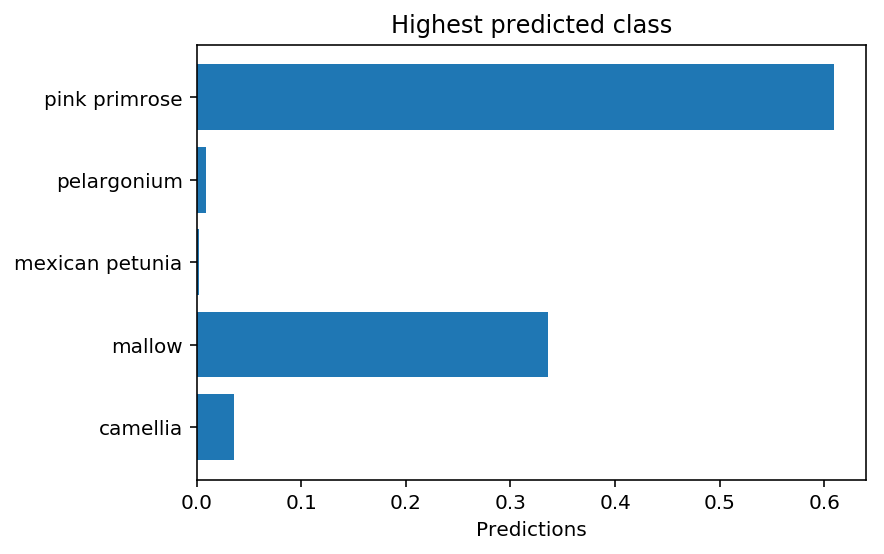

In [25]:
check_sanity2(df)